In [1]:
%load_ext autoreload
%autoreload 2

import os

import torch
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
from tqdm import tqdm

from moment.utils.config import Config
from moment.utils.utils import parse_config
from moment.utils.forecasting_metrics import get_forecasting_metrics
from moment.data.dataloader import get_timeseries_dataloader
from moment.data.forecasting_datasets import get_forecasting_datasets, ShortForecastingDataset
from moment.models.base import BaseModel
from moment.models.moment import MOMENT

### TODOs
#### Check that I hava implemented the data processing accurately
#### STL decomposition

In [2]:
short_forecasting_datasets = get_forecasting_datasets(collection="monash")
fred_forecasting_datasets = get_forecasting_datasets(collection="fred/preprocessed")

In [3]:
print("M3 datasets:")
m_datasets_base_path = '/'.join(short_forecasting_datasets[0].split('/')[:-1])
print(f"--- M3 & M4 datasets (base path): {m_datasets_base_path}")
print("--- M3 splits:", [i.split('/')[-1] for i in short_forecasting_datasets if "m3" in i])
print("--- M4 splits:", [i.split('/')[-1] for i in short_forecasting_datasets if "m4" in i])

print("Fred datasets:")
fred_datasets_base_path = '/'.join(fred_forecasting_datasets[0].split('/')[:-1])
print(f"--- FRED datasets (base path): {fred_datasets_base_path}")
print('--- Splits:', [i.split('/')[-1] for i in fred_forecasting_datasets if "fred" in i])

M3 datasets:
--- M3 & M4 datasets (base path): /XXXX-14/project/public/XXXX-9/TimeseriesDatasets/forecasting/monash
--- M3 splits: ['m3_other_dataset.tsf', 'm3_yearly_dataset.tsf', 'm3_monthly_dataset.tsf', 'm3_quarterly_dataset.tsf']
--- M4 splits: ['m4_daily_dataset.tsf', 'm4_weekly_dataset.tsf', 'm4_yearly_dataset.tsf', 'm4_monthly_dataset.tsf', 'm4_hourly_dataset.tsf', 'm4_quarterly_dataset.tsf']
Fred datasets:
--- FRED datasets (base path): /XXXX-14/project/public/XXXX-9/TimeseriesDatasets/forecasting/fred/preprocessed
--- Splits: ['fred_daily_dataset.npy', 'fred_yearly_dataset.npy', 'fred_weekly_dataset.npy', 'fred_monthly_dataset.npy', 'fred_quarterly_dataset.npy']


In [4]:
def get_dataloaders(args):
    args.dataset_names = args.full_file_path_and_name
    args.data_split = 'train'
    train_dataloader = get_timeseries_dataloader(args=args)
    args.data_split = 'test'
    test_dataloader = get_timeseries_dataloader(args=args)
    args.data_split = 'val'
    val_dataloader = get_timeseries_dataloader(args=args)
    return train_dataloader, test_dataloader, val_dataloader

def load_pretrained_moment(args,
                         pretraining_task_name: str = "pre-training"):
    args.task_name = pretraining_task_name
        
    checkpoint = BaseModel.load_pretrained_weights(
        run_name=args.pretraining_run_name, 
        opt_steps=args.pretraining_opt_steps)
    
    pretrained_model = MOMENT(configs=args)
    pretrained_model.load_state_dict(checkpoint["model_state_dict"])
    
    return pretrained_model

def merge_dataloaders(*dataloaders):
    for dataloader in dataloaders:
        for batch_x in dataloader:
            yield batch_x

In [7]:
DEFAULT_CONFIG_PATH = "../../configs/default.yaml"
GPU_ID = 0
FREQUENCY = "yearly" # "monthly" | "quarterly" | "yearly" | "daily" | "hourly" | "weekly" | "other"
DATASET = "fred" # "m3" | "m4" | "fred"
BASE_PATH = m_datasets_base_path if DATASET in ['m3', 'm4'] else fred_datasets_base_path

config = Config(config_file_path="../../configs/forecasting/zero_shot.yaml", 
                default_config_file_path=DEFAULT_CONFIG_PATH).parse()
config['device'] = GPU_ID if torch.cuda.is_available() else 'cpu'

args = parse_config(config)

file_format = 'tsf' if DATASET in ['m3', 'm4'] else 'npy'
args.full_file_path_and_name = os.path.join(BASE_PATH, f"{DATASET}_{FREQUENCY}_dataset.{file_format}")    
args.batch_size = 1

args.dataset_names = args.full_file_path_and_name

train_dataloader, test_dataloader, val_dataloader = get_dataloaders(args)
print(f"Forecast horizon: {train_dataloader.dataset.forecast_horizon}")
print(f"Lengths: Train: {train_dataloader.dataset.length_dataset} | Test: {test_dataloader.dataset.length_dataset} | Val: {val_dataloader.dataset.length_dataset}")

Forecast horizon: 6
Lengths: Train: 112816 | Test: 56408 | Val: 18804


In [3]:
from torch.nn.modules.loss import _Loss
import torch.nn.functional as F
from torch import Tensor

In [2]:
class sMAPELoss(_Loss):
    __constants__ = ['reduction']
    def __init__(self, size_average=None, reduce=None, reduction: str = 'mean') -> None:
        super().__init__(size_average, reduce, reduction)

    def _abs(input):
        return F.l1_loss(input, torch.zeros_like(input), reduction='none')
    
    def _divide_no_nan(self, a: float, b: float) -> float:
        """
        Auxiliary funtion to handle divide by 0
        """
        div = a / b
        div[div != div] = 0.0
        div[div == float('inf')] = 0.0
        return div

    def forward(self, input: Tensor, target: Tensor) -> Tensor:
        delta_y = self._abs(input - target)
        scale = self._abs(target) + self._abs(input)
        error = self._divide_no_nan(delta_y, scale)
        error = 200 * torch.mean(error)  
        
        return error

torch.nn.modules.loss._Loss

In [7]:
model = load_pretrained_moment(args)
model.to(args.device)
model.eval()

Loading latest model checkpoint at 55000 steps


BETT(
  (normalizer): RevIN()
  (tokenizer): Patching()
  (patch_embedding): PatchEmbedding(
    (value_embedding): Linear(in_features=8, out_features=1024, bias=False)
    (position_embedding): PositionalEmbedding()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=1024, bias=False)
              (k): Linear(in_features=1024, out_features=1024, bias=False)
              (v): Linear(in_features=1024, out_features=1024, bias=False)
              (o): Linear(in_features=1024, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 16)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            

In [7]:
from statsmodels.tsa.seasonal import STL

In [ ]:
## Other   : STL(timeseries, seasonal=7, period=7).fit()
## Monthly : STL(timeseries, seasonal=13, period=12).fit()

In [58]:
def get_forecasting_results(dataloader, model):
    
    forecast_horizon = dataloader.dataset.forecast_horizon
    
    input_timeseries = []
    input_masks = []
    true_forecasts = []
    pred_forecasts = []
    output_reconstructions = []

    with torch.no_grad():
        for batch_x in tqdm(dataloader, total=len(dataloader)):
            
            # timeseries = batch_x.timeseries.float().to(GPU_ID)
            
            timeseries = batch_x.timeseries.squeeze().numpy()
            decomposition = STL(timeseries, seasonal=13, period=12).fit()
            timeseries = np.concatenate(
                [decomposition.trend[np.newaxis, :], 
                 decomposition.seasonal[np.newaxis, :], 
                 decomposition.resid[np.newaxis, :],], axis=0)
            timeseries = torch.from_numpy(timeseries).unsqueeze(1).float().to(GPU_ID)
            
            forecasts_true = batch_x.forecast.float()
            input_mask = batch_x.input_mask.long().to(GPU_ID)

            outputs = model.short_forecast(x_enc=timeseries, 
                                        input_mask=input_mask,
                                        forecast_horizon=forecast_horizon)
            
            reconstruction = outputs.reconstruction.detach().cpu().numpy().sum(axis=0, keepdims=True)
            forecasts_pred = outputs.forecast.detach().cpu().numpy().sum(axis=0, keepdims=True)
            
            input_mask = input_mask.cpu().numpy()
            timeseries = timeseries.sum(axis=0, keepdims=True).detach().cpu().numpy()
            # timeseries = timeseries.detach().cpu().numpy()

            input_timeseries.append(timeseries)
            input_masks.append(input_mask)
            true_forecasts.append(forecasts_true)
            pred_forecasts.append(forecasts_pred)
            output_reconstructions.append(reconstruction)

        input_timeseries = np.concatenate(input_timeseries, axis=0)
        input_masks = np.concatenate(input_masks, axis=0)
        true_forecasts = np.concatenate(true_forecasts, axis=0)
        pred_forecasts = np.concatenate(pred_forecasts, axis=0)
        # output_reconstructions = np.concatenate(output_reconstructions, axis=0)
        # input_context_forecast = np.concatenate([input_timeseries[:, :, forecast_horizon:], 
        #                                         true_forecasts], axis=-1)
        
        return input_timeseries, input_masks, true_forecasts, pred_forecasts

In [57]:
input_timeseries_test, input_masks_test, true_forecasts_test, pred_forecasts_test = get_forecasting_results(test_dataloader, model)
input_timeseries_val, input_masks_val, true_forecasts_val, pred_forecasts_val = get_forecasting_results(val_dataloader, model)

true_forecasts = np.concatenate([true_forecasts_val, true_forecasts_test], axis=0)
pred_forecasts = np.concatenate([pred_forecasts_val, pred_forecasts_test], axis=0)
forecasting_metrics = get_forecasting_metrics(y_hat=pred_forecasts, y=true_forecasts)
print(forecasting_metrics)

100%|██████████| 144/144 [00:03<00:00, 40.72it/s]

ForecastingMetrics(mae=1027.7516, mse=3031830.8, mape=27.518558502197266, smape=21.121756732463837, rmse=1741.2153)


In [59]:
input_timeseries_test, input_masks_test, true_forecasts_test, pred_forecasts_test = get_forecasting_results(test_dataloader, model)
input_timeseries_val, input_masks_val, true_forecasts_val, pred_forecasts_val = get_forecasting_results(val_dataloader, model)

true_forecasts = np.concatenate([true_forecasts_val, true_forecasts_test], axis=0)
pred_forecasts = np.concatenate([pred_forecasts_val, pred_forecasts_test], axis=0)
forecasting_metrics = get_forecasting_metrics(y_hat=pred_forecasts, y=true_forecasts)
print(forecasting_metrics)

100%|██████████| 144/144 [00:03<00:00, 39.62it/s]

ForecastingMetrics(mae=990.561, mse=2763027.2, mape=26.51861608028412, smape=20.34098505973816, rmse=1662.2356)


In [48]:
forecast_horizon = test_dataloader.dataset.forecast_horizon
with torch.no_grad():
    for batch_x in tqdm(test_dataloader, total=len(test_dataloader)):
        
        # timeseries = batch_x.timeseries.float().to(GPU_ID)
        
        timeseries = batch_x.timeseries.squeeze().numpy()
        decomposition = STL(timeseries, seasonal=13, period=12).fit()
        timeseries = np.concatenate(
            [decomposition.trend[np.newaxis, :], 
                decomposition.seasonal[np.newaxis, :], 
                decomposition.resid[np.newaxis, :],], axis=0)
        timeseries = torch.from_numpy(timeseries).unsqueeze(1).float().to(GPU_ID)
        
        forecasts_true = batch_x.forecast.float()
        input_mask = batch_x.input_mask.long().to(GPU_ID)

        outputs = model.short_forecast(x_enc=timeseries, 
                                    input_mask=input_mask,
                                    forecast_horizon=forecast_horizon)
        break

  0%|          | 0/428 [00:00<?, ?it/s]


In [54]:
decomposition = STL(test_dataloader.dataset.data.series_value.iloc[0], seasonal=13, period=12).fit()

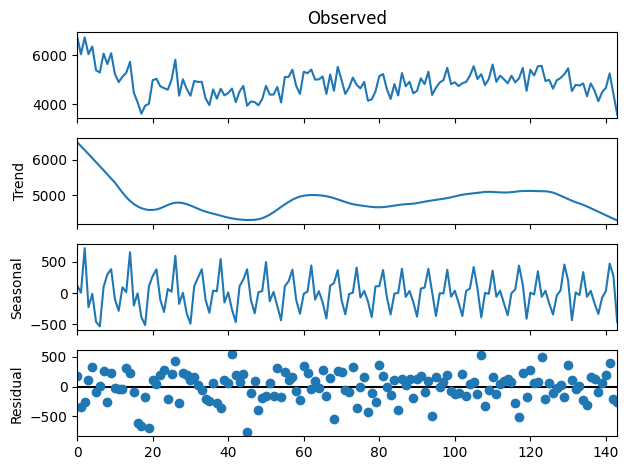

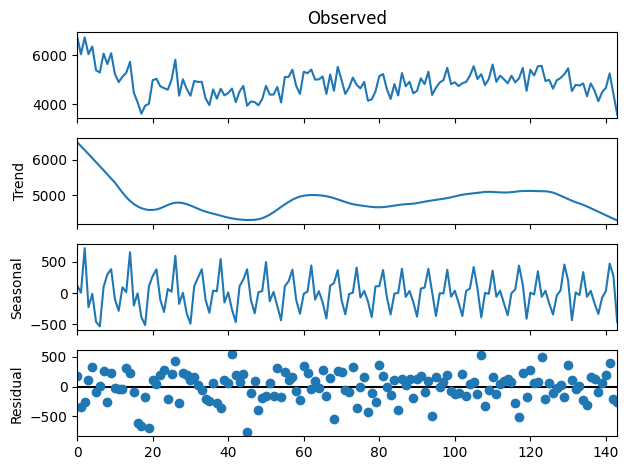

In [55]:
decomposition.plot()

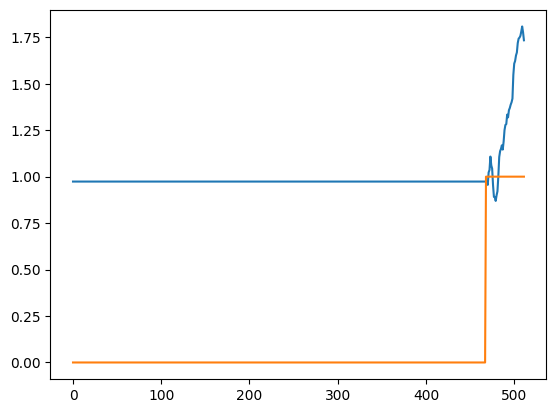

In [120]:
plt.plot(batch_x.timeseries.detach().cpu().numpy().squeeze()/4000)
plt.plot(batch_x.input_mask.detach().cpu().numpy().squeeze())

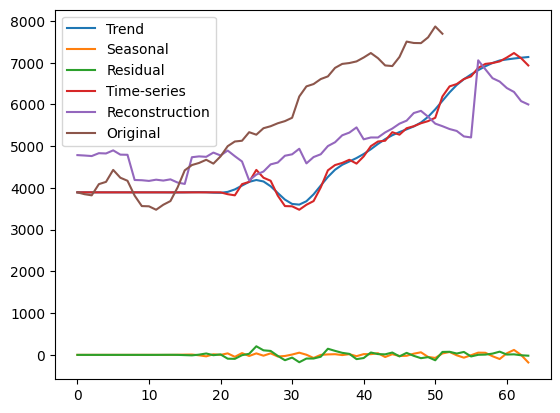

In [113]:
plt.plot(timeseries[0, 0, -64:].detach().cpu().numpy(), label="Trend")
plt.plot(timeseries[1, 0, -64:].detach().cpu().numpy(), label="Seasonal")
plt.plot(timeseries[2, 0, -64:].detach().cpu().numpy(), label="Residual")
plt.plot(timeseries.detach().cpu().numpy().squeeze().sum(axis=0)[-64:], label="Time-series")
plt.plot(outputs.reconstruction[0, 0, -64:].detach().cpu().numpy(), label="Reconstruction")
plt.plot(test_dataloader.dataset.data.series_value.iloc[0], label="Original")
plt.legend()
plt.show()

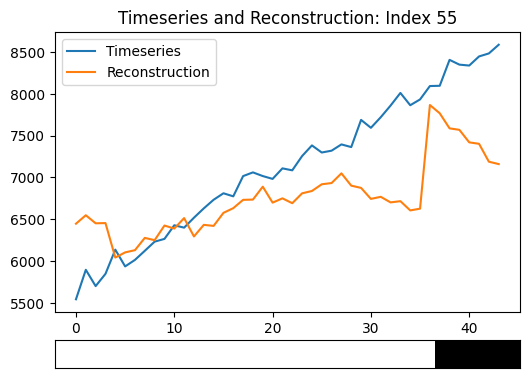

In [88]:
forecast_horizon = train_dataloader.dataset.forecast_horizon
idx = np.random.randint(0, output_reconstructions.shape[0])

fig, axs = plt.subplots(2, 1, figsize=(6, 8))  # Set the figure size to (6, 8)

first_valid_time = np.argmax(input_masks[idx, :])
forecasting_mask = np.ones_like(input_masks)
forecasting_mask[:, -forecast_horizon:] = 0

axs[0].set_title("Timeseries and Reconstruction: Index {}".format(idx))
axs[0].plot(input_context_forecast[idx, 0, first_valid_time:], label="Timeseries")
axs[0].plot(output_reconstructions[idx, 0, first_valid_time:], label="Reconstruction")
axs[1].imshow(forecasting_mask[idx, first_valid_time:].reshape(1, -1), cmap='gray', aspect='auto')
axs[0].legend()

# Set the height of the second subplot to be smaller
axs[1].set_position([axs[1].get_position().x0, 
                     axs[1].get_position().y0 + 0.35, 
                     axs[1].get_position().width, 
                     axs[1].get_position().height * 0.1])

# Remove the x and y ticks of the second subplot
axs[1].set_xticks([])
axs[1].set_yticks([])
plt.show()